In [117]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt 
import json


In [118]:
orders = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks/2_orders.json")) 
initial_fill = json.load(open("../1_environment/slapstack/slapstack/use_cases/wepastacks/3_initial_fill_lvl.json"))

In [4]:
order_columns = ['type', 'sku', 'time', 'dock', 'batch', 'week']
order_df = pd.DataFrame(orders, columns=order_columns)

# Sort the orders by time
order_df = order_df.sort_values(by='time').reset_index(drop=True)

# Calculate the time difference between consecutive orders
order_df['time_diff'] = order_df['time'].diff()

# Define a threshold for breaks (e.g., 1200 seconds for a 20-minute break)
threshold = 1200

# Identify breaks
breaks = order_df[order_df['time_diff'] > threshold]

# Display the breaks
print(breaks[['time', 'time_diff']])

           time  time_diff
596      172800    68700.0
14218    345600    12410.0
16296    432000    20665.0
21875    518400     9312.0
30262    691282     7308.0
...         ...        ...
392997  7430400    33672.0
399742  7516800    18535.0
411575  7650000     1320.0
411615  7653600     3240.0
411715  7657200     3600.0

[77 rows x 2 columns]


In [23]:
def process_orders_by_week(orders, initial_fill):
    # Create a DataFrame from the orders
    order_columns = ['type', 'sku', 'time', 'dock', 'batch', 'week']
    order_df = pd.DataFrame(orders, columns=order_columns)
    order_df['day'] = order_df['time'] // (24 * 3600)
    
    # Initialize the fill levels from the initial fill data
    fill_levels = initial_fill.copy()

    # Store fill levels at the beginning of each week
    weekly_fill_levels = {}

    # Process orders week by week
    for week in sorted(order_df['week'].unique()):
        # Get orders for the current week
        weekly_orders = order_df[order_df['week'] == week]
        
        # Store the fill level at the beginning of the week
        weekly_fill_levels[week] = fill_levels.copy()
        
        # Process each order for the current week
        for _, order in weekly_orders.iterrows():
            order_type, sku = order['type'], str(order['sku'])
            
            # For delivery, increase the stock of the SKU
            if order_type == "delivery":
                fill_levels[sku] = fill_levels.get(sku, 0) + 1
            # For retrieval, decrease the stock of the SKU
            elif order_type == "retrieval":
                fill_levels[sku] = fill_levels.get(sku, 0) - 1

    return weekly_fill_levels, order_df

# Process the orders and calculate weekly fill levels
weekly_fill_levels, order_df = process_orders_by_week(orders, initial_fill)

# Print the fill levels at the beginning of each week
for week, fill in weekly_fill_levels.items():
    print(f"Week {week}: Fill levels: {fill}")

Week 1: Fill levels: {'1': 1, '2': 268, '3': 157, '4': 5, '6': 28, '7': 461, '8': 74, '9': 375, '10': 187, '11': 308, '12': 138, '17': 526, '18': 453, '20': 28, '21': 102, '23': 34, '24': 4, '25': 52, '26': 229, '27': 262, '28': 1154, '29': 271, '30': 611, '31': 62, '32': 36, '33': 961, '34': 85, '35': 270, '38': 278, '39': 268, '43': 469, '45': 4, '46': 11, '49': 39, '50': 83, '52': 10, '53': 1095, '54': 2, '57': 202, '58': 36, '59': 88, '61': 203, '62': 1857, '63': 246, '64': 179, '65': 39, '67': 126, '68': 484, '69': 3, '70': 12, '72': 6, '73': 3, '75': 2, '78': 218, '79': 659, '81': 1, '82': 3, '83': 27, '84': 10, '85': 42, '86': 22, '89': 73}
Week 2: Fill levels: {'1': 1, '2': 268, '3': 157, '4': 5, '6': 28, '7': 461, '8': 74, '9': 375, '10': 187, '11': 308, '12': 138, '17': 526, '18': 603, '20': 166, '21': 102, '23': 34, '24': 4, '25': 52, '26': 229, '27': 262, '28': 1154, '29': 271, '30': 611, '31': 62, '32': 36, '33': 961, '34': 85, '35': 270, '38': 278, '39': 268, '43': 469, '

C:\Users\zm0714\AppData\Local\Temp\ipykernel_28940\1983772289.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  first_week_orders['hour'] = order_df['time'] // 3600  # Convert time to hours


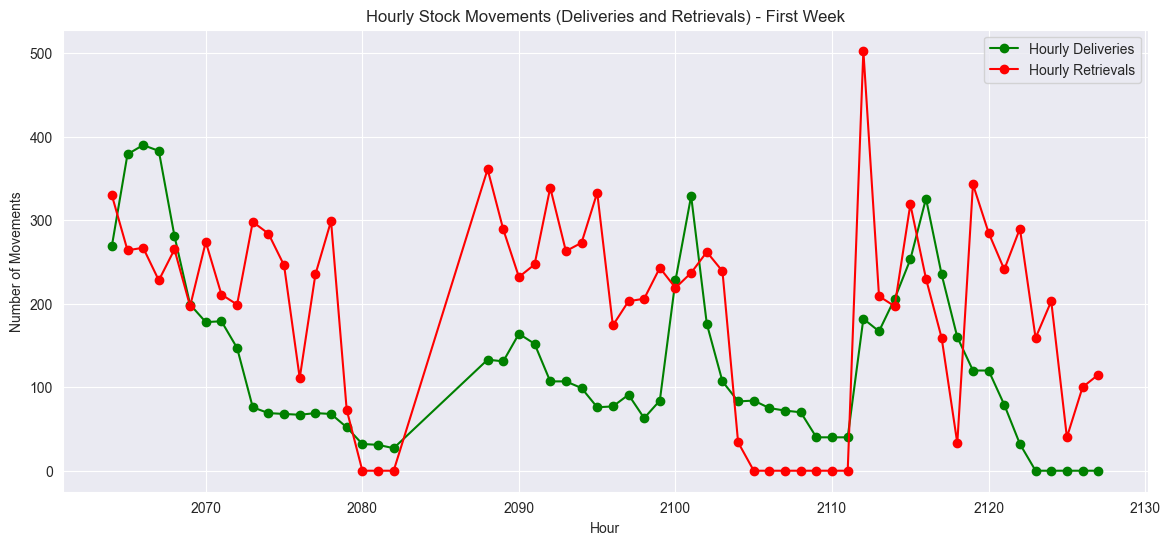

In [37]:
import matplotlib.pyplot as plt

# Function to visualize hourly stock movements (deliveries and retrievals)
def visualize_hourly_stock_movements(weekly_fill_levels, order_df, week=1):
    # Filter the orders for the given week and get the unique hours within this week
    first_week_orders = order_df[order_df['week'] == week]
    first_week_orders['hour'] = order_df['time'] // 3600  # Convert time to hours
    hours_in_week = sorted(first_week_orders['hour'].unique())

    # Initialize fill levels for aggregation at the start of the week
    fill_levels_at_start = weekly_fill_levels[week].copy()

    # Store the hourly changes in stock
    hourly_delivery_movements = []
    hourly_retrieval_movements = []
    
    # Process each hour within the week
    for hour in hours_in_week:
        hour_orders = first_week_orders[first_week_orders['hour'] == hour]

        # Track delivery and retrieval counts for the hour
        hourly_deliveries = 0
        hourly_retrievals = 0

        # Process each order within the hour
        for _, order in hour_orders.iterrows():
            order_type, sku = order['type'], str(order['sku'])
            if order_type == "delivery":
                hourly_deliveries += 1
                fill_levels_at_start[sku] = fill_levels_at_start.get(sku, 0) + 1
            elif order_type == "retrieval":
                hourly_retrievals += 1
                fill_levels_at_start[sku] = fill_levels_at_start.get(sku, 0) - 1

        # Append the hourly movements (deliveries and retrievals)
        hourly_delivery_movements.append(hourly_deliveries)
        hourly_retrieval_movements.append(hourly_retrievals)
    
    # Plot the hourly stock movements (deliveries and retrievals)
    plt.figure(figsize=(14, 6))
    plt.plot(hours_in_week, hourly_delivery_movements, label="Hourly Deliveries", color='g', marker='o')
    plt.plot(hours_in_week, hourly_retrieval_movements, label="Hourly Retrievals", color='r', marker='o')

    plt.title("Hourly Stock Movements (Deliveries and Retrievals) - First Week")
    plt.xlabel("Hour")
    plt.ylabel("Number of Movements")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.show()

# Example usage:
# Call visualize_hourly_stock_movements with the data processed
visualize_hourly_stock_movements(weekly_fill_levels, order_df, week=14)


In [39]:
order_df.groupby(by="week").count() 

,type,sku,time,dock,batch,day
week,,,,,,
1,596,596,596,596,596,596
2,31691,31691,31691,31691,31691,31691
3,34610,34610,34610,34610,34610,34610
4,37134,37134,37134,37134,37134,37134
5,36978,36978,36978,36978,36978,36978
6,36668,36668,36668,36668,36668,36668
7,33250,33250,33250,33250,33250,33250
8,32453,32453,32453,32453,32453,32453
9,28102,28102,28102,28102,28102,28102


In [32]:
i = 0
print(len(orders))
orders_new = []
for order in orders:
    if i < 20000:
        orders_new.append(order)
    else:
        break
    i += 1

411830


In [22]:
len(orders_new)

20000

In [18]:
#del orders_new[300000:320000]

In [26]:
json.dump(orders_new, open("../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/2_orders.json", "w"))

In [119]:
use_case = "wepastacks"

In [120]:
layout = pd.read_csv(f"../1_environment/slapstack/slapstack/use_cases/{use_case}/1_layout.csv", header=None, delimiter=",")

In [121]:
layout.dropna(axis=1, how='all', inplace=True)

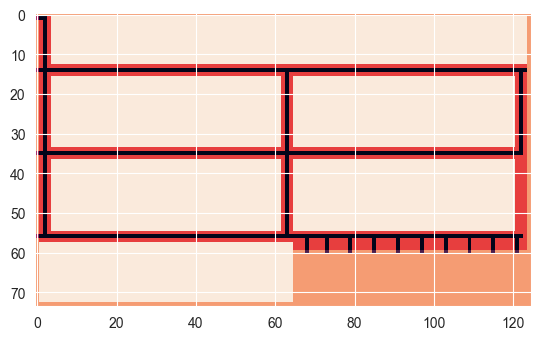

In [122]:
plt.imshow(layout)

In [123]:
def gen_charging_stations(layout, n_cs):
    charging_locs = [len(layout.columns) * i // (n_cs + 1) for i in range(1, n_cs + 1)]
    aisle = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -6 if i in charging_locs else -2 for i in range(len(layout.columns))}, index=[1])
    aisle1 = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.columns))}, index=[2])
    line = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -2 if i == 1 else -5 for i in range(len(layout.columns))}, index=[3])
    aisle2 = pd.DataFrame({i: -1 if i == 0 or i == len(layout.columns)-1 else -5 if i == 2 else -2 for i in range(len(layout.columns))}, index=[4])
    
    layout_new = pd.concat([layout.iloc[:1], aisle, aisle1, line, aisle2, layout.iloc[1:]]).reset_index(drop=True)
    return layout_new

def gen_charging_stations_left(layout, n_cs):
    # Calculate the positions for charging stations
    charging_locs = [len(layout.index) * i // (n_cs + 1) for i in range(1, n_cs + 1)]
    
    # Create new columns for the charging stations and aisles
    aisle = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -6 if i in charging_locs else -2 for i in range(len(layout.index))})
    aisle1 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    #line = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -2 if i == 1 else -5 for i in range(len(layout.index))})
    # aisle2 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    # aisle3 = pd.Series({i: -1 if i == 0 or i == len(layout.index)-1 else -5 if i in charging_locs else -2 for i in range(len(layout.index))})
    
    # Concatenate the new columns with the existing layout, preserving the structure
    layout_new = pd.concat([
        layout.iloc[:, :1],  # First column of original layout
        pd.DataFrame({0: aisle, 1: aisle1}),  # New columns
        layout.iloc[:, 2:]  # Rest of the original layout
    ], axis=1)
    
    # Reset and rename the columns
    layout_new.columns = range(len(layout_new.columns))
    
    return layout_new
    

In [127]:
if use_case == "wepastacks":
    layout_new = gen_charging_stations(layout, 20)
elif use_case == "crossstacks":
    layout_new = gen_charging_stations_left(layout, 4)

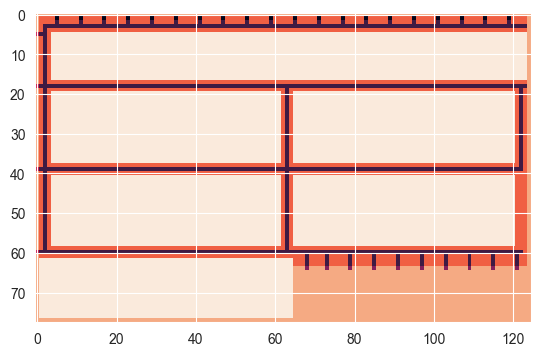

In [128]:
plt.imshow(layout_new)

In [129]:
layout_new.to_csv(f"../1_environment/slapstack/slapstack/use_cases/{use_case}_bm/1_layout.csv", header=None, index=False)

In [ ]:
import json
root_dir_partitions = '../1_environment/slapstack/slapstack/use_cases/wepastacks_bm/partitions/'

def load_partitions_data(path):
    col_orders = ["order", "SKU", "arrival", "dock", "batch", "week"]
    col_fill_lvl = ["SKU", "amount"]
    orders = json.load(open(f'{path}_orders.json')) 
    fill_level = json.load(open(f'{path}_fill_lvl.json')) 
    return (pd.DataFrame(columns=col_orders, data=orders), 
            pd.DataFrame.from_dict(data=fill_level, orient='index'))

orders_dict = dict({})
fill_lvls_dict = dict({})
n_partitions = 20

for pt_idx in range(n_partitions):
    orders_dict[pt_idx] = []
    fill_lvls_dict[pt_idx] = []
    orders, fill_level = load_partitions_data(f'{root_dir_partitions}{pt_idx}_partition')
    if orders is not None:
        orders_dict[pt_idx].append(orders)
    if fill_level is not None:
        fill_lvls_dict[pt_idx].append(fill_level)
        
total_locations = 19512
fill_lvls = []
for pt_idx in range(n_partitions):
    fill_lvls.append(float((fill_lvls_dict[pt_idx][0].sum() / total_locations) * 100))
    
def agg_overall_stocklevels(row):
    global current_stock_overall
    
    #update current_stock_overall
    current_level = row['amount_change'] + current_stock_overall
    current_stock_overall = current_level
    return current_level

def convert_time(row):
    return pd.Timestamp(row["arrival"], unit='s') 

total_locations = 19512

for idx in orders_dict.keys():
    current_partition = orders_dict[idx][0]
    current_partition.loc[current_partition['order'] == 'retrieval', 'amount_change'] = -1
    current_partition.loc[current_partition['order'] == 'delivery', 'amount_change'] = 1

    current_stock_overall = fill_lvls_dict[idx][0].sum()
    
    current_partition['current_stock_overall'] = current_partition.apply(agg_overall_stocklevels, axis = 1)
    current_partition["fill_level"] = current_partition["current_stock_overall"] / total_locations
    
    current_partition["arrival_datetime"] = current_partition.apply(lambda x: convert_time(x), axis=1)
    current_partition["date"] = current_partition["arrival_datetime"].apply(lambda x: x.strftime("%Y-%m-%d"))
    current_partition["day"] = current_partition["arrival_datetime"].apply(lambda x: x.weekday())
    current_partition["hour"] = current_partition["arrival_datetime"].apply(lambda x: x.hour)
    current_partition["partition"] = idx
    try:
        assert  fill_lvls_dict[idx+1][0].sum()[0] == current_partition.iloc[-1]["current_stock_overall"]
    except KeyError:
        print("Key")